# Imports

In [1]:
import json
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn import preprocessing as preproc
from sklearn.decomposition import PCA
import numpy as np

# https://stackoverflow.com/questions/52285104/3d-scatterplots-with-hue-colormap-and-legend
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

try:
  from google.colab import drive
  drive.mount('/content/drive')

  COLAB = True
except ModuleNotFoundError:
  COLAB = False

%matplotlib inline

# Load Data

In [2]:
df = pd.read_parquet("diabetic_data_cleaned.parquet")

# fix some types that parquet didn't get right
df["admission_type_id"] = df["admission_type_id"].astype("category")
df["discharge_disposition_id"] = df["discharge_disposition_id"].astype("category")
df["admission_source_id"] = df["admission_source_id"].astype("category")

display(df.shape)
display(df.dtypes)
display(df.head(2).T)

(100244, 31)

race                        category
gender                      category
age                         category
admission_type_id           category
discharge_disposition_id    category
admission_source_id         category
time_in_hospital               int64
payer_code                  category
medical_specialty           category
num_lab_procedures             int64
num_procedures                 int64
num_medications                int64
number_outpatient              int64
number_emergency               int64
number_inpatient               int64
diag_1                      category
diag_2                      category
diag_3                      category
number_diagnoses               int64
metformin                   category
repaglinide                 category
glimepiride                 category
glipizide                   category
glyburide                   category
pioglitazone                category
rosiglitazone               category
insulin                     category
g

,1,2
race,Caucasian,AfricanAmerican
gender,Female,Female
age,[10-20),[20-30)
admission_type_id,1,1
discharge_disposition_id,1,1
admission_source_id,7,7
time_in_hospital,3,2
payer_code,NaN,NaN
medical_specialty,NaN,NaN
num_lab_procedures,59,11


In [3]:
with open("data_dictionary.json", "r") as f:
  data_info = json.load(f)

NUM_COLUMNS = data_info["Numeric Columns"]
CAT_COLUMNS = data_info["Categorical Columns"]
TGT = data_info["Target"]

# PCA

In [4]:
x = df[NUM_COLUMNS]
x = preproc.MinMaxScaler().fit_transform(x)

In [5]:
feat_cols = ['feature'+str(i) for i in range(x.shape[1])]
normalised_numericals = pd.DataFrame(x, columns=feat_cols)
normalised_numericals.head()

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7
0,0.153846,0.442748,0.000000,0.2125,0.000000,0.0,0.000000,0.461538
1,0.076923,0.076336,0.833333,0.1500,0.047619,0.0,0.047619,0.230769
2,0.076923,0.328244,0.166667,0.1875,0.000000,0.0,0.000000,0.307692
3,0.000000,0.381679,0.000000,0.0875,0.000000,0.0,0.000000,0.153846
4,0.153846,0.229008,1.000000,0.1875,0.000000,0.0,0.000000,0.461538


In [6]:
pca = PCA(n_components=8)
principalComponents_readmit = pca.fit_transform(x)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.46842595 0.27776598 0.10332927 0.09305336 0.0335908  0.01843882
 0.00467294 0.00072288]


In [7]:
pcs = 8
pc_df = pd.DataFrame(data = principalComponents_readmit[:, :pcs],
                     columns = [f"PC{i}" for i in range(1, pcs+1)])
print(f"variance explained: {sum(pca.explained_variance_ratio_[:pcs])})")

# merge with the target variable
pc_df = pd.concat([pc_df, df], axis = 1)

# print all rows
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pc_df.head(2).T)

variance explained: 1.0)


,0,1
PC1,-0.214843,0.417941
PC2,0.070744,-0.522845
PC3,-0.194516,0.160733
PC4,0.002981,0.05501
PC5,0.034456,-0.033519
PC6,-0.04246,0.043855
PC7,-0.010517,0.040114
PC8,-0.001318,-0.004334
race,NaN,Caucasian
gender,NaN,Female


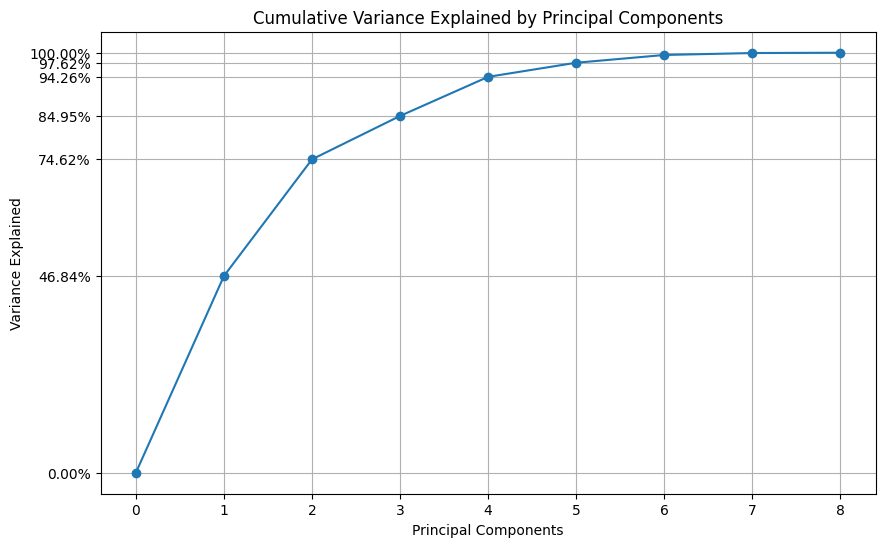

In [43]:
variances = {0: 0} | {
    i: sum(pca.explained_variance_ratio_[:i])
    for i in range(1, pca.n_components_+1)
}
x = list(variances.keys())
y = list(variances.values())

plt.figure(figsize=(10, 6))
plt.plot(x, y, marker = "o")

plt.xticks(x)
plt.yticks(
    y[:6] + [y[-1]],
    [f"{k:.2%}" for k in y[:6] + [y[-1]]],
)

plt.xlabel("Principal Components")
plt.ylabel("Variance Explained")
plt.title("Cumulative Variance Explained by Principal Components")

plt.grid(True)

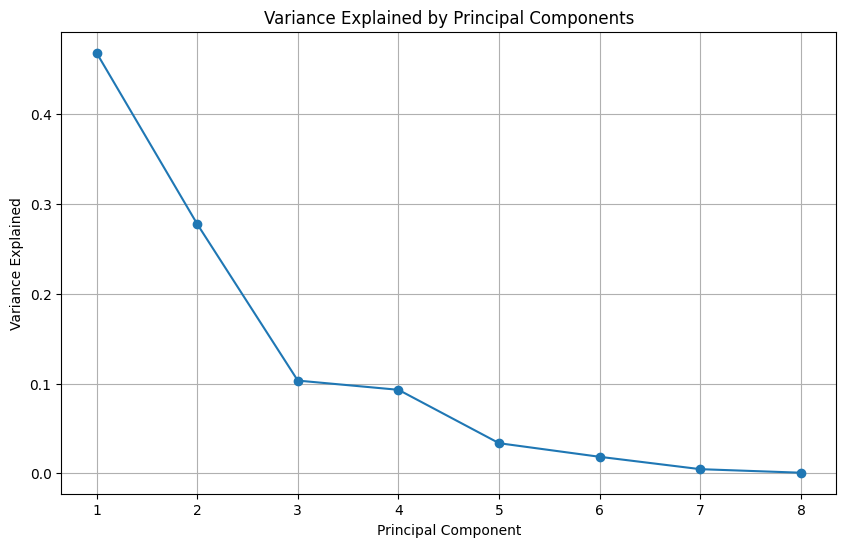

In [42]:
# plot variance explained not cumulative with a x-axis 1-based
plt.figure(figsize=(10, 6))
plt.plot(range(1, pca.n_components_+1), pca.explained_variance_ratio_, marker = "o")
plt.xticks(range(1, pca.n_components_+1))
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.title("Variance Explained by Principal Components")
plt.grid(True)
plt.show()

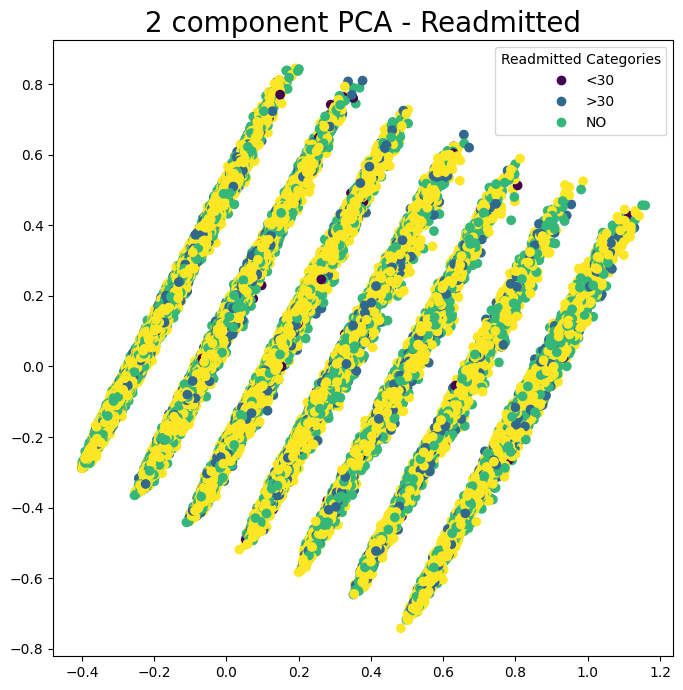

In [10]:
# Create a scatter plot
fig = plt.figure(figsize=(8, 8))
plt.title('2 component PCA - Readmitted', fontsize=20)
scatter = plt.scatter(
    pc_df['PC1'],
    pc_df['PC2'],
    c=pc_df['readmitted'].astype("category").cat.codes,  # Use category codes for coloring
    cmap='viridis'
)

categories = pc_df['readmitted'].astype("category").cat.categories
codes = pc_df['readmitted'].astype("category").cat.codes.unique()

cmap = mpl.colormaps['viridis'].resampled(len(codes))
handles = [plt.Line2D([], [], marker='o', linestyle='', color=cmap(code), label=category)
           for category, code in zip(categories, codes)]
plt.legend(handles=handles, title="Readmitted Categories")

plt.show()

Text(0.5, 1.0, 'Correlation PCs and Numerical Columns')

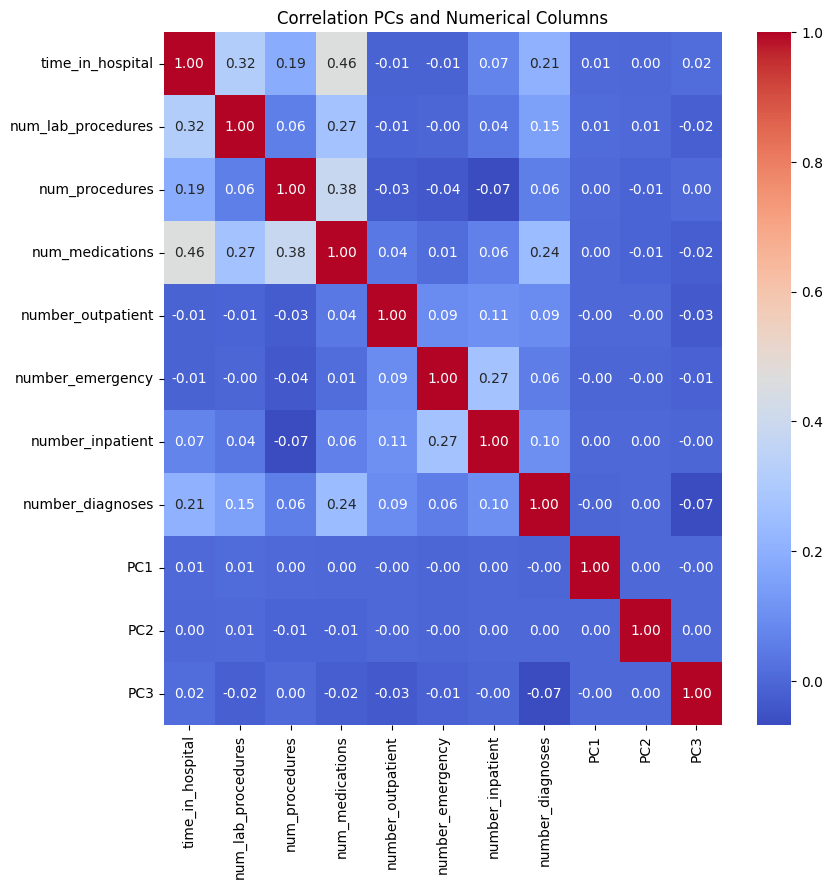

In [11]:
# do correlation of the first two PCs with the NUM_COLUMNS
corrs = pc_df[NUM_COLUMNS + ["PC1", "PC2", "PC3"]].corr()

# plot the correlation matrix
plt.figure(figsize=(9, 9))
sns.heatmap(corrs, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation PCs and Numerical Columns")

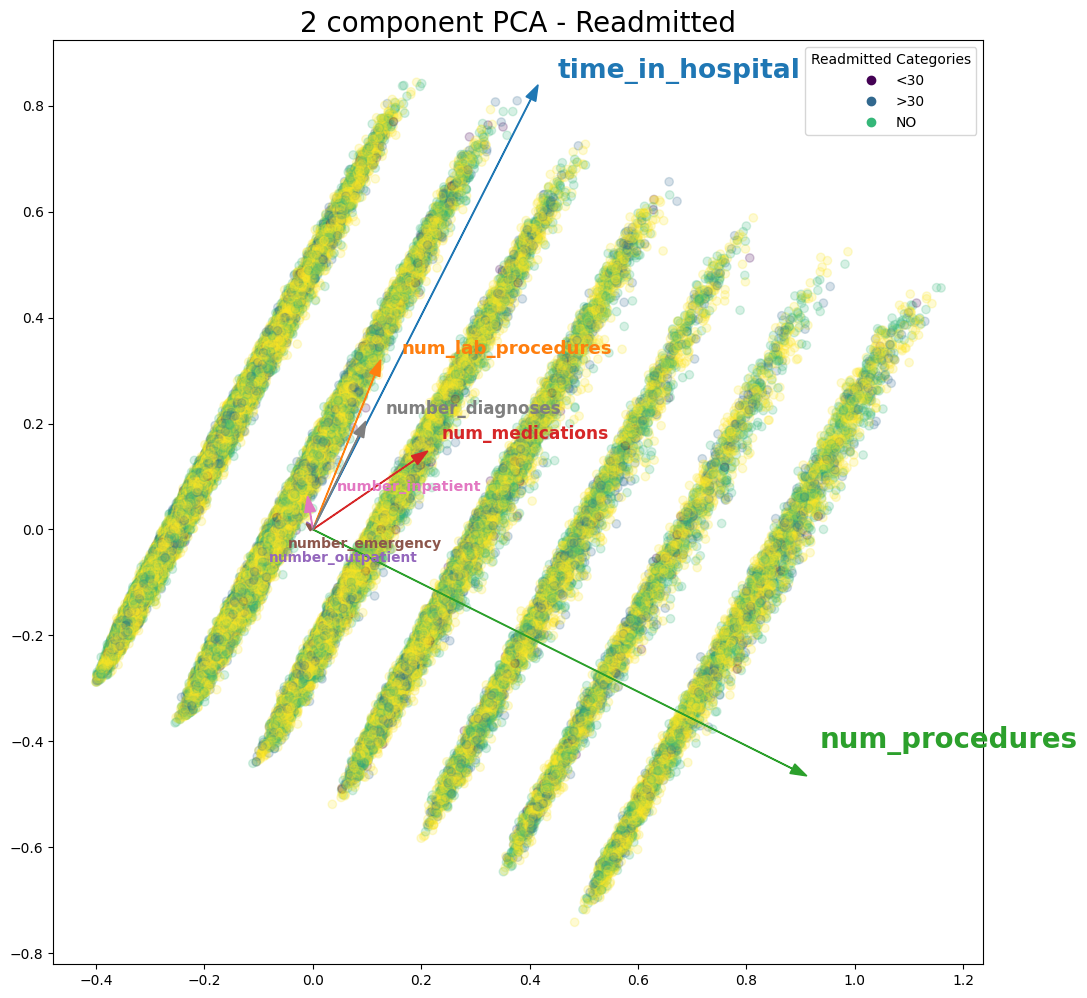

In [36]:
# plot the other numerical columns as vectors over the plot of the first two PCs
fig = plt.figure(figsize=(12, 12))
plt.title('2 component PCA - Readmitted', fontsize=20)
scatter = plt.scatter(
    pc_df['PC1'],
    pc_df['PC2'],
    c=pc_df['readmitted'].astype("category").cat.codes, 
    alpha=.2,
    cmap='viridis'
)

categories = pc_df['readmitted'].astype("category").cat.categories
codes = pc_df['readmitted'].astype("category").cat.codes.unique()

cmap = mpl.colormaps['viridis'].resampled(len(codes))
handles = [plt.Line2D([], [], marker='o', linestyle='', color=cmap(code), label=category)
           for category, code in zip(categories, codes)]

plt.legend(handles=handles, title="Readmitted Categories")

for i, (comp1, comp2) in enumerate(zip(pca.components_[0], pca.components_[1])):
    norm = np.linalg.norm([comp1, comp2])
    if max([comp1, comp2]) < .02:
        plt.arrow(0, 0, comp1, comp2, color=f"C{i}", head_width=.01)
        plt.text(comp1 - .05 * 500*norm, comp2 - .04 * 500*norm, NUM_COLUMNS[i], color=f"C{i}", fontsize=10-20*norm, fontweight="bold")
    else:
        # get arrow norm
        plt.arrow(0, 0, comp1, comp2, color=f"C{i}", head_width=.02)
        plt.text(comp1 + .05, comp2 + .04, NUM_COLUMNS[i], color=f"C{i}", fontsize=10+10*norm, fontweight="bold")

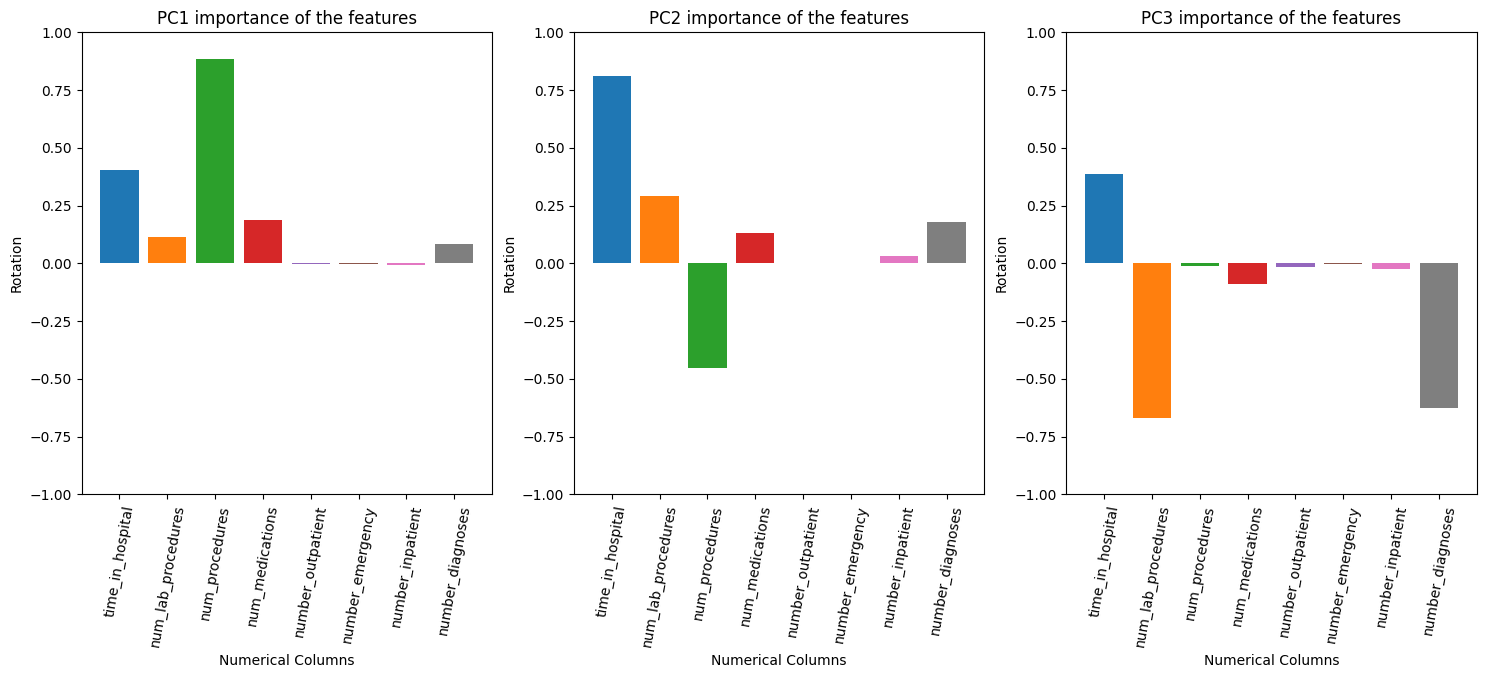

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

for i, pc in enumerate(["PC1", "PC2", "PC3"]):
    ax[i].set_title(f"PC{i+1} importance of the features")
    ax[i].set_xticks(range(len(NUM_COLUMNS)))
    ax[i].set_xticklabels(NUM_COLUMNS, rotation=80)
    ax[i].set_ylabel("Rotation")
    ax[i].set_xlabel("Numerical Columns")
    ax[i].bar(NUM_COLUMNS, pca.components_[i], color=[f"C{i}" for i in range(len(NUM_COLUMNS))])
    ax[i].set_ylim(-1, 1)

### Conclusion

Using the cumulative and non-cumulative graphs, we conclude that using the first 3 principal components rather than the 8 original numerical variables is fine since it doesn't lead to a significant loss of information. When training the models, try both. The other graphs can be used in the report to explain the principal components of our dataset.